# Calidad de resultados segun k y alpha

## Pre - Experimentacion

In [34]:
# make cpp libraries
!cd ../../ && mkdir build
!cd ../../build/ && rm -rf *
!cd ../../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/lucas/.virtualenvs/metnum_tp2/bin/python (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lucas/Desktop/MetNum/TP/TP2/metnum_tp2
-- Configuring d

In [35]:
# verifico version de python e importo metnum
!pwd
!python --version

import sys
import os

p = os.path.abspath('../')
sys.path.insert(1, p)

import metnum

/home/lucas/Desktop/MetNum/TP/TP2/metnum_tp2/notebooks/calidad_k_alpha
Python 3.8.10


In [36]:
#funcion general del modelo
def predict(X_train, y_train, X_val, alpha, k, con_pca):
    
    clf = metnum.KNNClassifier(k)
    
    if con_pca:
        
        pca = metnum.PCA(alpha)
        pca.fit(X_train)
        
        X_train = pca.transform(X_train)
        X_val = pca.transform(X_val)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    return y_pred

In [12]:
import numpy as np

def k_folds(X,y, folds):
    
    fold_size = int(X.shape[0]/folds)
    
    X_folds = []
    y_folds = []
    
    for i in range(folds):
        
        if (i + 1)*fold_size < X.shape[0]: limit = (i + 1)*fold_size
        else: limit = X.shape[0]
        
        X_folds.append(X[i*fold_size:limit])
        y_folds.append(y[i*fold_size:limit])
        
    return X_folds, y_folds

def join_folds(X_list, y_list):
    
    X_join = X_list[0]
    y_join = y_list[0]
    
    for i in range(1,len(X_list)):
    
        X_join = np.append(X_join, X_list[i], axis = 0)
        y_join = np.append(y_join, y_list[i], axis = 0)
        
    return X_join, y_join

In [38]:
# metrics

def compare_value(y_predict, y_val, i):
    
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for j in range(len(y_val)):
        
        if y_val[j][0] == i:
            if y_predict[j][0] == i: tp+=1
            else: fn += 1
        else:
            if y_predict[j][0] == i: fp += 1
            else: tn += 1

    return tp, tn, fp, fn
            
def metrics_value(y_pred, y_val, i):
    
    tp, tn, fp, fn = compare_value(y_pred, y_val, i)
    
    acc = (tp + tn)/(tp + tn + fp + fn)
    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    
    return acc, prec, rec

def metrics(y_pred, y_val):
    
    acc_sum = 0
    prec_sum = 0
    rec_sum = 0
    
    for i in range(10):
        
        acc, prec, rec = metrics_value(y_pred, y_val, i)
        
        acc_sum += acc
        prec_sum += prec
        rec_sum += rec
        
    return acc_sum/10, prec_sum/10, rec_sum/10

In [39]:
# Extraigo data set MNIST
%load_ext autoreload
%autoreload 2

import pandas as pd

df_train = pd.read_csv("../../data/train.csv")

df_train = df_train.sample(frac = 1) # shuffle df

#df_train = df_train[:5000]

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

## KNN (sin PCA)

In [41]:
#Particiono los datos
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

In [42]:
k_list = [1,2,5,10,20,50,100]

acc_list = []
prec_list = []
rec_list = []

print("hey")

for k in k_list:
    
    print("k: " + str(k))
    
    y_pred = predict(X_train, y_train, X_val, 0,  k, False)
    y_pred = y_pred.reshape(len(y_pred), 1)
    acc, prec, rec = metrics(y_pred, y_val)
    
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    
print("enjoy your data")

hey


  0%|                                                     | 0/7 [00:00<?, ?it/s]

k: 1


 14%|██████▎                                     | 1/7 [04:57<29:44, 297.35s/it]

k: 2


 29%|████████████▌                               | 2/7 [09:39<24:03, 288.61s/it]

k: 5


 43%|██████████████████▊                         | 3/7 [14:24<19:06, 286.73s/it]

k: 10


 57%|█████████████████████████▏                  | 4/7 [19:08<14:17, 285.84s/it]

k: 20


 71%|███████████████████████████████▍            | 5/7 [23:44<09:24, 282.33s/it]

k: 50


 86%|█████████████████████████████████████▋      | 6/7 [28:13<04:37, 277.60s/it]

k: 100


100%|████████████████████████████████████████████| 7/7 [32:48<00:00, 281.15s/it]

enjoy your data


## KNN con PCA

In [46]:
k_list = [1,2,5,10,20,50,100]
alpha_list = [1,5,10,50,100]

acc_list_pca = []
prec_list_pca = []
rec_list_pca = []

print("hey")

for k in k_list:
    
    for alpha in alpha_list:
        
        print("k: " + str(k) + " alpha: " + str(alpha))
    
        y_pred = predict(X_train, y_train, X_val, alpha,  k, True)
        y_pred = y_pred.reshape(len(y_pred), 1)
        acc, prec, rec = metrics(y_pred, y_val)
        
        acc_list_pca.append(acc)
        prec_list_pca.append(prec)
        rec_list_pca.append(rec)

print("enjoy your data")

hey
k: 1 alpha: 1
k: 1 alpha: 5
k: 1 alpha: 10
k: 1 alpha: 50
k: 1 alpha: 100
k: 2 alpha: 1
k: 2 alpha: 5
k: 2 alpha: 10
k: 2 alpha: 50
k: 2 alpha: 100
k: 5 alpha: 1
k: 5 alpha: 5
k: 5 alpha: 10
k: 5 alpha: 50
k: 5 alpha: 100
k: 10 alpha: 1
k: 10 alpha: 5
k: 10 alpha: 10
k: 10 alpha: 50
k: 10 alpha: 100
k: 20 alpha: 1
k: 20 alpha: 5
k: 20 alpha: 10
k: 20 alpha: 50
k: 20 alpha: 100
k: 50 alpha: 1
k: 50 alpha: 5
k: 50 alpha: 10
k: 50 alpha: 50
k: 50 alpha: 100
k: 100 alpha: 1
k: 100 alpha: 5
k: 100 alpha: 10
k: 100 alpha: 50
k: 100 alpha: 100
enjoy your data


In [47]:
acc_list_pca = np.array(acc_list_pca)
prec_list_pca = np.array(prec_list_pca)
rec_list_pca = np.array(rec_list_pca)

## Data analisys

In [2]:
import json

In [54]:
# Guardar datos en archivo

data = {
    "k_list": list(k_list),
    "alpha_list": list(alpha_list),
    "acc_list": list(acc_list),
    "prec_list": list(prec_list),
    "rec_list": list(rec_list),
    "acc_list_pca": list(acc_list_pca),
    "prec_list_pca": list(prec_list_pca),
    "rec_list_pca": list(rec_list_pca)
}

with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)

In [6]:
# Leer datos de archivo

with open('data.txt') as json_file:
    data = json.load(json_file)

In [103]:
#Asigno datos lectura de archivos

k_list = np.array(data["k_list"])
alpha_list = np.array(data["alpha_list"])
acc_list = np.array(data["acc_list"])
prec_list = np.array(data["prec_list"])
rec_list = np.array(data["rec_list"])
acc_list_pca = np.array(data["acc_list_pca"])
prec_list_pca = np.array(data["prec_list_pca"])
rec_list_pca = np.array(data["rec_list_pca"])

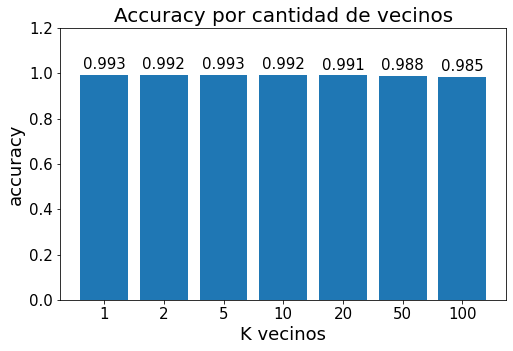

In [104]:
plt.figure(figsize = (8,5))

rec = plt.bar( ["1","2","5","10","20","50","100"], list(map(lambda x: round(x,3),acc_list)))
plt.title("Accuracy por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("accuracy", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

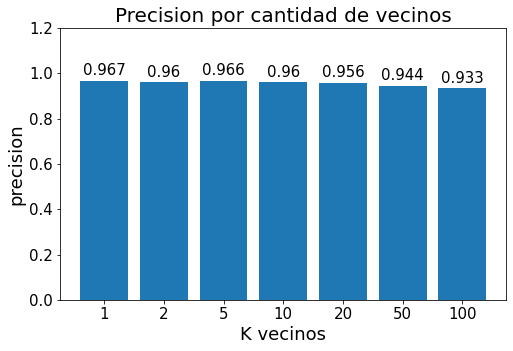

In [105]:
plt.figure(figsize = (8,5))

rec = plt.bar( ["1","2","5","10","20","50","100"], list(map(lambda x: round(x,3),prec_list)))
plt.title("Precision por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("precision", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

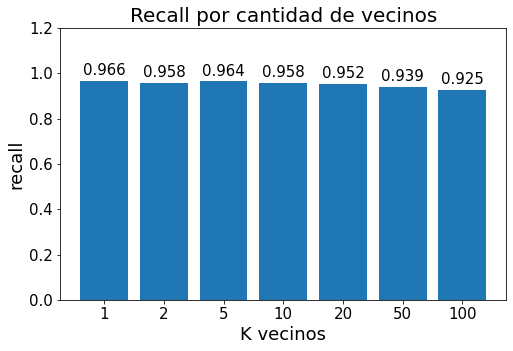

In [106]:
plt.figure(figsize = (8,5))

rec = plt.bar(list(map(lambda x: str(x), k_list)), list(map(lambda x: round(x,3),rec_list)))
plt.title("Recall por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("recall", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [107]:
import seaborn as sns

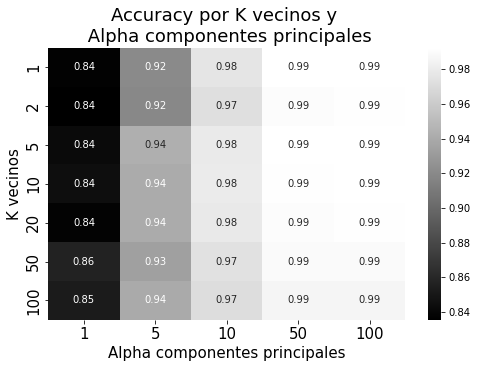

In [108]:
plt.figure(figsize = (8,5))

sns.heatmap(acc_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Accuracy por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

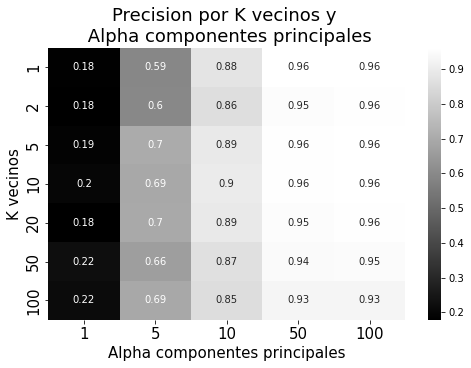

In [109]:
plt.figure(figsize = (8,5))

sns.heatmap(prec_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Precision por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [ ]:
plt.figure(figsize = (8,5))

sns.heatmap(rec_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title(" por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()